# FSRS4Anki v3.17.0 Optimizer

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v3.17.0/fsrs4anki_optimizer.ipynb)

↑ Click the above button to open the optimizer on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

Upload your **Anki Deck Package (.apkg)** file or **Anki Collection Package (.colpkg)** file on the `Left sidebar -> Files`, drag and drop your file in the current directory (not the `sample_data` directory). 

No need to include media. Need to include scheduling information. 

> If you use the latest version of Anki, please check the box `Support older Anki versions (slower/larger files)` when you export.

You can export it via `File -> Export...` or `Ctrl + E` in the main window of Anki.

Then replace the `filename` with yours in the next code cell. And set the `timezone` and `next_day_starts_at` which can be found in your preferences of Anki.

After that, just run all (`Runtime -> Run all` or `Ctrl + F9`) and wait for minutes. You can see the optimal parameters in section **2.3 Result**. Copy them, replace the parameters in `fsrs4anki_scheduler.js`, and paste them into the custom scheduling of your deck options (require Anki version >= 2.1.55).

**NOTE**: The default output is generated from my review logs. If you find the output is the same as mine, maybe your notebook hasn't run there.

**Contribute to SRS Research**: If you want to share your data with me, please fill this form: https://forms.gle/KaojsBbhMCytaA7h8

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"


## 1 Build dataset

### 1.1 Extract Anki collection & deck file

In [2]:
import zipfile
import sqlite3
import time
from tqdm import notebook
import pandas as pd
import numpy as np
import os
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import math
import sys
import torch
from torch import nn
from sklearn.utils import shuffle
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'./{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Extract successfully!")


Extract successfully!


### 1.2 Create time-series feature & analysis

The following code cell will extract the review logs from your Anki collection and preprocess them to a trainset which is saved in `revlog_history.tsv`.

The time-series features are important in optimizing the model's parameters. For more detail, please see my paper: https://www.maimemo.com/paper/

Then it will generate a concise analysis for your review logs. 

- The `r_history` is the history of ratings on each review. `3,3,3,1` means that you press `Good, Good, Good, Again`. It only contains the first rating for each card on the review date, i.e., when you press `Again` in review and  `Good` in relearning steps 10min later, only `Again` will be recorded.
- The `avg_interval` is the actual average interval after you rate your cards as the `r_history`. It could be longer than the interval given by Anki's built-in scheduler because you reviewed some overdue cards.
- The `avg_retention` is the average retention after you press as the `r_history`. `Again` counts as failed recall, and `Hard, Good and Easy` count as successful recall. Retention is the percentage of your successful recall.
- The `stability` is the estimated memory state variable, which is an approximate interval that leads to 90% retention.
- The `factor` is `stability / previous stability`.
- The `group_cnt` is the number of review logs that have the same `r_history`.

In [3]:
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute("SELECT * FROM revlog")
revlog = res.fetchall()

df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl',
              'last_lvl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000) &
        (df['r'] > 0)].copy()
df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize(
    'UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize(
    'UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)
type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")
df = df[df['type'] != 3].copy()
df['real_days'] = df['review_date'] - timedelta(hours=next_day_starts_at)
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['delta_t'] = df['delta_t'].astype(dtype=int)
df['i'] = 1
df['r_history'] = ""
df['t_history'] = ""
col_idx = {key: i for i, key in enumerate(df.columns)}


# code from https://github.com/L-M-Sherlock/anki_revlog_analysis/blob/main/revlog_analysis.py
def get_feature(x):
    last_kind = None
    for idx, log in enumerate(x.itertuples()):
        if last_kind is not None and last_kind in (1, 2) and log.type == 0:
            return x.iloc[:idx]
        last_kind = log.type
        if idx == 0:
            if log.type != 0:
                return x.iloc[:idx]
            x.iloc[idx, col_idx['delta_t']] = 0
        if idx == x.shape[0] - 1:
            break
        x.iloc[idx + 1, col_idx['i']] = x.iloc[idx, col_idx['i']] + 1
        x.iloc[idx + 1, col_idx['t_history']] = f"{x.iloc[idx, col_idx['t_history']]},{x.iloc[idx, col_idx['delta_t']]}"
        x.iloc[idx + 1, col_idx['r_history']] = f"{x.iloc[idx, col_idx['r_history']]},{x.iloc[idx, col_idx['r']]}"
    return x

notebook.tqdm.pandas()
df = df.groupby('cid', as_index=False, group_keys=False).progress_apply(get_feature)
df = df[df['id'] >= time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000]
df["t_history"] = df["t_history"].map(lambda x: x[1:] if len(x) > 1 else x)
df["r_history"] = df["r_history"].map(lambda x: x[1:] if len(x) > 1 else x)
df.to_csv('revlog_history.tsv', sep="\t", index=False)
print("Trainset saved.")

def cal_retention(group: pd.DataFrame) -> pd.DataFrame:
    group['retention'] = round(group['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x]).mean(), 4)
    group['total_cnt'] = group.shape[0]
    return group

df = df.groupby(by=['r_history', 'delta_t'], group_keys=False).progress_apply(cal_retention)
print("Retention calculated.")
df = df.drop(columns=['id', 'cid', 'usn', 'ivl', 'last_lvl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'r', 't_history'])
df.drop_duplicates(inplace=True)
df['retention'] = df['retention'].map(lambda x: max(min(0.99, x), 0.01))

def cal_stability(group: pd.DataFrame) -> pd.DataFrame:
    group_cnt = sum(group['total_cnt'])
    if group_cnt < 10:
        return pd.DataFrame()
    group['group_cnt'] = group_cnt
    if group['i'].values[0] > 1:
        r_ivl_cnt = sum(group['delta_t'] * group['retention'].map(np.log) * pow(group['total_cnt'], 2))
        ivl_ivl_cnt = sum(group['delta_t'].map(lambda x: x ** 2) * pow(group['total_cnt'], 2))
        group['stability'] = round(np.log(0.9) / (r_ivl_cnt / ivl_ivl_cnt), 1)
    else:
        group['stability'] = 0.0
    group['avg_retention'] = round(sum(group['retention'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 3)
    group['avg_interval'] = round(sum(group['delta_t'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 1)
    del group['total_cnt']
    del group['retention']
    del group['delta_t']
    return group

df = df.groupby(by=['r_history'], group_keys=False).progress_apply(cal_stability)
print("Stability calculated.")
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace=True)
df.sort_values(by=['r_history'], inplace=True, ignore_index=True)

if df.shape[0] > 0:
    for idx in notebook.tqdm(df.index):
        item = df.loc[idx]
        index = df[(df['i'] == item['i'] + 1) & (df['r_history'].str.startswith(item['r_history']))].index
        df.loc[index, 'last_stability'] = item['stability']
    df['factor'] = round(df['stability'] / df['last_stability'], 2)
    df = df[(df['i'] >= 2) & (df['group_cnt'] >= 100)]
    df['last_recall'] = df['r_history'].map(lambda x: x[-1])
    df = df[df.groupby(['i', 'r_history'], group_keys=False)['group_cnt'].transform(max) == df['group_cnt']]
    df.to_csv('./stability_for_analysis.tsv', sep='\t', index=None)
    print("1:again, 2:hard, 3:good, 4:easy\n")
    print(df[df['r_history'].str.contains(r'^[1-4][^124]*$', regex=True)][['r_history', 'avg_interval', 'avg_retention', 'stability', 'factor', 'group_cnt']].to_string(index=False))
    print("Analysis saved!")

revlog.csv saved.


  0%|          | 0/30711 [00:00<?, ?it/s]

Trainset saved.


  0%|          | 0/95123 [00:00<?, ?it/s]

Retention calculated.


  0%|          | 0/63978 [00:00<?, ?it/s]

Stability calculated.


  0%|          | 0/1190 [00:00<?, ?it/s]

1:again, 2:hard, 3:good, 4:easy

      r_history  avg_interval  avg_retention  stability  factor  group_cnt
              1           1.7          0.765        1.0     inf       7997
            1,3           3.9          0.876        4.2    4.20       4176
          1,3,3           8.6          0.883        9.2    2.19       2711
        1,3,3,3          18.2          0.858       14.0    1.52       1616
      1,3,3,3,3          37.5          0.835       23.2    1.66        822
    1,3,3,3,3,3          78.8          0.850       35.6    1.53        384
  1,3,3,3,3,3,3         122.3          0.903       39.3    1.10        171
              2           1.0          0.901        1.1     inf        240
            2,3           3.5          0.946        8.3    7.55        201
          2,3,3          11.1          0.890        7.1    0.86        160
              3           1.5          0.962        5.4     inf       9134
            3,3           3.9          0.966       15.2    2.81    

## 2 Optimize parameter

### 2.1 Define the model

FSRS is a time-series model for predicting memory states.

In [4]:
init_w = [1, 1, 5, -0.5, -0.5, 0.2, 1.4, -0.12, 0.8, 2, -0.2, 0.2, 1]
'''
w[0]: initial_stability_for_again_answer
w[1]: initial_stability_step_per_rating
w[2]: initial_difficulty_for_good_answer
w[3]: initial_difficulty_step_per_rating
w[4]: next_difficulty_step_per_rating
w[5]: next_difficulty_reversion_to_mean_speed (used to avoid ease hell)
w[6]: next_stability_factor_after_success
w[7]: next_stability_stabilization_decay_after_success
w[8]: next_stability_retrievability_gain_after_success
w[9]: next_stability_factor_after_failure
w[10]: next_stability_difficulty_decay_after_success
w[11]: next_stability_stability_gain_after_failure
w[12]: next_stability_retrievability_gain_after_failure
For more details about the parameters, please see: 
https://github.com/open-spaced-repetition/fsrs4anki/wiki/Free-Spaced-Repetition-Scheduler
'''


class FSRS(nn.Module):
    def __init__(self, w):
        super(FSRS, self).__init__()
        self.w = nn.Parameter(torch.FloatTensor(w))
        self.zero = torch.FloatTensor([0.0])

    def forward(self, x, s, d):
        '''
        :param x: [review interval, review response]
        :param s: stability
        :param d: difficulty
        :return:
        '''
        if torch.equal(s, self.zero):
            # first learn, init memory states
            new_s = self.w[0] + self.w[1] * (x[1] - 1)
            new_d = self.w[2] + self.w[3] * (x[1] - 3)
            new_d = new_d.clamp(1, 10)
        else:
            r = torch.exp(np.log(0.9) * x[0] / s)
            new_d = d + self.w[4] * (x[1] - 3)
            new_d = self.mean_reversion(self.w[2], new_d)
            new_d = new_d.clamp(1, 10)
            # recall
            if x[1] > 1:
                new_s = s * (1 + torch.exp(self.w[6]) *
                             (11 - new_d) *
                             torch.pow(s, self.w[7]) *
                             (torch.exp((1 - r) * self.w[8]) - 1))
            # forget
            else:
                new_s = self.w[9] * torch.pow(new_d, self.w[10]) * torch.pow(
                    s, self.w[11]) * torch.exp((1 - r) * self.w[12])
        return new_s, new_d

    def loss(self, s, t, r):
        return - (r * np.log(0.9) * t / s + (1 - r) * torch.log(1 - torch.exp(np.log(0.9) * t / s)))

    def mean_reversion(self, init, current):
        return self.w[5] * init + (1-self.w[5]) * current


class WeightClipper(object):
    def __init__(self, frequency=1):
        self.frequency = frequency

    def __call__(self, module):
        if hasattr(module, 'w'):
            w = module.w.data
            w[0] = w[0].clamp(0.1, 10)
            w[1] = w[1].clamp(0.1, 5)
            w[2] = w[2].clamp(1, 10)
            w[3] = w[3].clamp(-5, -0.1)
            w[4] = w[4].clamp(-5, -0.1)
            w[5] = w[5].clamp(0, 0.5)
            w[6] = w[6].clamp(0, 2)
            w[7] = w[7].clamp(-0.2, -0.01)
            w[8] = w[8].clamp(0.01, 1.5)
            w[9] = w[9].clamp(0.5, 5)
            w[10] = w[10].clamp(-2, -0.01)
            w[11] = w[11].clamp(0.01, 0.9)
            w[12] = w[12].clamp(0.01, 2)
            module.w.data = w

def lineToTensor(line):
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor


### 2.2 Train the model

The `revlog_history.tsv` generated before will be used for training the FSRS model.

In [5]:
model = FSRS(init_w)
lr = 5e-4
clipper = WeightClipper()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

dataset = pd.read_csv("./revlog_history.tsv", sep='\t', index_col=None, dtype={'r_history': str ,'t_history': str} )
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (dataset['t_history'].str.count(',0') == 0)]
dataset['tensor'] = dataset.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
dataset['y'] = dataset['r'].map({1: 0, 2: 1, 3: 1, 4: 1})
print("Tensorized!")

pre_train_set = dataset[dataset['i'] == 2]
# pretrain
epoch_len = len(pre_train_set)
pbar = notebook.tqdm(desc="pre-train", colour="red", total=epoch_len)


for i, (_, row) in enumerate(shuffle(pre_train_set, random_state=2022).iterrows()):
    model.train()
    optimizer.zero_grad()
    output_t = [(model.zero, model.zero)]
    for input_t in row['tensor']:
        output_t.append(model(input_t, *output_t[-1]))
    loss = model.loss(output_t[-1][0], row['delta_t'], row['y'])
    if np.isnan(loss.data.item()):
        # Exception Case
        print(row, output_t)
        raise Exception('error case')
    loss.backward()
    optimizer.step()
    model.apply(clipper)
    pbar.update()
pbar.close()
for name, param in model.named_parameters():
    print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")

train_set = dataset[dataset['i'] > 2]
epoch_len = len(train_set)
n_epoch = 1
print_len = max(epoch_len*n_epoch // 10, 1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epoch_len * n_epoch)
pbar = notebook.tqdm(desc="train", colour="red", total=epoch_len*n_epoch)

for k in range(n_epoch):
    for i, (_, row) in enumerate(shuffle(train_set, random_state=2022 + k).iterrows()):
        model.train()
        optimizer.zero_grad()
        output_t = [(model.zero, model.zero)]
        for input_t in row['tensor']:
            output_t.append(model(input_t, *output_t[-1]))
        loss = model.loss(output_t[-1][0], row['delta_t'], row['y'])
        if np.isnan(loss.data.item()):
            # Exception Case
            print(row, output_t)
            raise Exception('error case')
        loss.backward()
        for param in model.parameters():
            param.grad[:2] = torch.zeros(2)
        optimizer.step()
        scheduler.step()
        model.apply(clipper)
        pbar.update()

        if (k * epoch_len + i) % print_len == 0:
            print(f"iteration: {k * epoch_len + i + 1}")
            for name, param in model.named_parameters():
                print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")
pbar.close()

w = list(map(lambda x: round(float(x), 4), dict(model.named_parameters())['w'].data))

print("\nTraining finished!")


  0%|          | 0/223795 [00:00<?, ?it/s]

Tensorized!


pre-train:   0%|          | 0/28970 [00:00<?, ?it/s]

w: [1.0185, 2.2626, 5.0, -0.5, -0.5, 0.2, 1.4, -0.12, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/194825 [00:00<?, ?it/s]

iteration: 1
w: [1.0185, 2.2627, 5.0, -0.5, -0.5, 0.2, 1.4, -0.12, 0.8, 2.0, -0.2, 0.2, 1.0]
iteration: 19483
w: [1.0186, 2.2627, 5.0903, -0.6072, -0.6289, 0.0655, 1.3368, -0.1636, 0.736, 1.959, -0.2437, 0.1995, 0.9742]
iteration: 38965
w: [1.0186, 2.2627, 5.1858, -0.8629, -0.7647, 0.0079, 1.3373, -0.1095, 0.7334, 1.9292, -0.2777, 0.3056, 0.9802]
iteration: 58447
w: [1.0186, 2.2627, 5.22, -1.1028, -0.8442, 0.007, 1.3983, -0.01, 0.7855, 1.8532, -0.3541, 0.436, 0.9392]
iteration: 77929
w: [1.0186, 2.2627, 5.2743, -1.1535, -0.9878, 0.0052, 1.3632, -0.0336, 0.7481, 1.8111, -0.3921, 0.5665, 0.9473]
iteration: 97411
w: [1.0186, 2.2627, 5.2364, -1.0918, -1.0398, 0.001, 1.3744, -0.0264, 0.7552, 1.7549, -0.4439, 0.5656, 0.9239]
iteration: 116893
w: [1.0186, 2.2627, 5.2509, -1.1411, -1.0739, 0.0126, 1.3556, -0.0334, 0.7323, 1.7688, -0.4287, 0.5979, 0.9047]
iteration: 136375
w: [1.0186, 2.2627, 5.2127, -1.1158, -1.0781, 0.0045, 1.3652, -0.0326, 0.7387, 1.7442, -0.4517, 0.5845, 0.8928]
iteration: 

### 2.3 Result

Copy the optimal parameters for FSRS for you in the output of next code cell after running.

In [6]:
print(w)

[1.0186, 2.2627, 5.1999, -1.1212, -1.065, 0.0109, 1.3647, -0.0251, 0.7361, 1.7358, -0.4576, 0.5997, 0.8907]


### 2.4 Preview

You can see the memory states and intervals generated by FSRS as if you press the good in each review at the due date scheduled by FSRS.

In [7]:
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9


class Collection:
    def __init__(self, w):
        self.model = FSRS(w)

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(list(zip([t_history], [r_history]))[0])
            output_t = [(self.model.zero, self.model.zero)]
            for input_t in line_tensor:
                output_t.append(self.model(input_t, *output_t[-1]))
            return output_t[-1]


my_collection = Collection(w)
print("1:again, 2:hard, 3:good, 4:easy\n")
for first_rating in (1,2,3,4):
    print(f'first rating: {first_rating}')
    t_history = "0"
    d_history = "0"
    r_history = f"{first_rating}"  # the first rating of the new card
    # print("stability, difficulty, lapses")
    for i in range(10):
        states = my_collection.states(t_history, r_history)
        # print('{0:9.2f} {1:11.2f} {2:7.0f}'.format(
            # *list(map(lambda x: round(float(x), 4), states))))
        next_t = max(round(float(np.log(requestRetention)/np.log(0.9) * states[0])), 1)
        difficulty = round(float(states[1]), 1)
        t_history += f',{int(next_t)}'
        d_history += f',{difficulty}'
        r_history += f",3"
    print(f"rating history: {r_history}")
    print(f"interval history: {t_history}")
    print(f"difficulty history: {d_history}")
    print('')


1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0,1,2,4,8,17,34,69,138,274,542
difficulty history: 0,7.4,7.4,7.4,7.4,7.3,7.3,7.3,7.3,7.3,7.2

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0,3,7,17,39,89,202,453,1006,2213,4823
difficulty history: 0,6.3,6.3,6.3,6.3,6.3,6.3,6.2,6.2,6.2,6.2

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0,6,15,40,103,262,657,1625,3966,9553,22717
difficulty history: 0,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2,5.2

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0,8,23,67,191,536,1475,3990,10616,27790,71600
difficulty history: 0,4.1,4.1,4.1,4.1,4.1,4.1,4.2,4.2,4.2,4.2



You can change the `test_rating_sequence` to see the scheduling intervals in different ratings.

In [8]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
easyBonus = 1.3
hardInterval = 1.2

t_history = "0"
d_history = "0"
for i in range(len(test_rating_sequence.split(','))):
    rating = test_rating_sequence[2*i]
    last_t = int(t_history.split(',')[-1])
    r_history = test_rating_sequence[:2*i+1]
    states = my_collection.states(t_history, r_history)
    print(states)
    next_t = max(1,round(float(np.log(requestRetention)/np.log(0.9) * states[0])))
    if rating == '4':
        next_t = round(next_t * easyBonus)
    elif rating == '2':
        next_t = round(last_t * hardInterval)
    t_history += f',{int(next_t)}'
    difficulty = round(float(states[1]), 1)
    d_history += f',{difficulty}'
print(f"rating history: {test_rating_sequence}")
print(f"interval history: {t_history}")
print(f"difficulty history: {d_history}")

(tensor(5.5440), tensor(5.1999))
(tensor(15.4987), tensor(5.1999))
(tensor(39.7972), tensor(5.1999))
(tensor(103.0389), tensor(5.1999))
(tensor(262.0583), tensor(5.1999))
(tensor(21.5402), tensor(7.3067))
(tensor(4.2994), tensor(9.3905))
(tensor(6.2102), tensor(9.3448))
(tensor(9.1258), tensor(9.2996))
(tensor(13.5695), tensor(9.2550))
(tensor(20.5815), tensor(9.2108))
(tensor(31.2465), tensor(9.1670))
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,6,15,40,103,262,22,4,6,9,14,21,31
difficulty history: 0,5.2,5.2,5.2,5.2,5.2,7.3,9.4,9.3,9.3,9.3,9.2,9.2


### 2.5 Predict memory states and distribution of difficulty

Predict memory states for each review and save them in `prediction.tsv`.

Meanwhile, it will count the distribution of difficulty.

In [9]:
def predict_memory_states(group):
    states = my_collection.states(*group.name)
    group['stability'] = float(states[0])
    group['difficulty'] = float(states[1])
    group['count'] = len(group)
    return pd.DataFrame({
        'r_history': [group.name[1]], 
        't_history': [group.name[0]], 
        'stability': [round(float(states[0]),2)], 
        'difficulty': [round(float(states[1]),2)], 
        'count': [len(group)] 
    })

prediction = dataset.groupby(by=['t_history', 'r_history']).progress_apply(predict_memory_states)
prediction.reset_index(drop=True, inplace=True)
prediction.sort_values(by=['r_history'], inplace=True)
prediction.to_csv("./prediction.tsv", sep='\t', index=None)
print("prediction.tsv saved.")
prediction['difficulty'] = prediction['difficulty'].map(lambda x: int(round(x)))
difficulty_distribution = prediction.groupby(by=['difficulty'])['count'].sum() / prediction['count'].sum()
print(difficulty_distribution)
difficulty_distribution_padding = np.zeros(10)
for i in range(10):
    if i+1 in difficulty_distribution.index:
        difficulty_distribution_padding[i] = difficulty_distribution.loc[i+1]

  0%|          | 0/117599 [00:00<?, ?it/s]

prediction.tsv saved.
difficulty
1     0.001850
2     0.010956
3     0.039505
4     0.154588
5     0.161152
6     0.066288
7     0.132528
8     0.060573
9     0.077607
10    0.294953
Name: count, dtype: float64


## 3 Optimize retention to minimize the time of reviews

Calculate the optimal retention to minimize the time for long-term memory consolidation. It is an experimental feature. You can use the simulator to get more accurate results:

https://github.com/open-spaced-repetition/fsrs4anki/blob/main/fsrs4anki_simulator.ipynb

average time for failed cards: 25.0s
average time for recalled cards: 8.0s
terminal stability:  361.62


  0%|          | 0/15 [00:00<?, ?it/s]

expected_time.csv saved.

-----suggested retention (experimental): 0.84-----


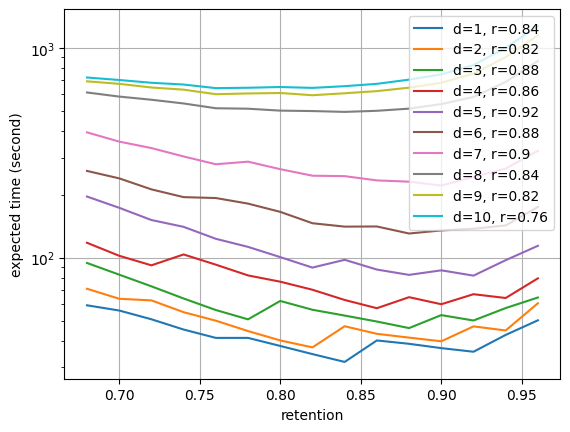

In [10]:
base = 1.01
index_len = 793
index_offset = 200
d_range = 10
d_offset = 1
r_time = 8
f_time = 25
max_time = 200000

type_block = dict()
type_count = dict()
type_time = dict()
last_t = type_sequence[0]
type_block[last_t] = 1
type_count[last_t] = 1
type_time[last_t] = time_sequence[0]
for i,t in enumerate(type_sequence[1:]):
    type_count[t] = type_count.setdefault(t, 0) + 1
    type_time[t] = type_time.setdefault(t, 0) + time_sequence[i]
    if t != last_t:
        type_block[t] = type_block.setdefault(t, 0) + 1
    last_t = t

r_time = round(type_time[1]/type_count[1]/1000, 1)

if 2 in type_count and 2 in type_block:
    f_time = round(type_time[2]/type_block[2]/1000 + r_time, 1)

print(f"average time for failed cards: {f_time}s")
print(f"average time for recalled cards: {r_time}s")

def stability2index(stability):
    return int(round(np.log(stability) / np.log(base)) + index_offset)

def init_stability(d):
    return max(((d - w[2]) / w[3] + 2) * w[1] + w[0], np.power(base, -index_offset))

def cal_next_recall_stability(s, r, d, response):
    if response == 1:
        return s * (1 + np.exp(w[6]) * (11 - d) * np.power(s, w[7]) * (np.exp((1 - r) * w[8]) - 1))
    else:
        return w[9] * np.power(d, w[10]) * np.power(s, w[11]) * np.exp((1 - r) * w[12])


stability_list = np.array([np.power(base, i - index_offset) for i in range(index_len)])
print(f"terminal stability: {stability_list.max(): .2f}")
df = pd.DataFrame(columns=["retention", "difficulty", "time"])

for percentage in notebook.tqdm(range(96, 66, -2)):
    recall = percentage / 100
    time_list = np.zeros((d_range, index_len))
    time_list[:,:-1] = max_time
    for d in range(d_range, 0, -1):
        s0 = init_stability(d)
        s0_index = stability2index(s0)
        diff = max_time
        while diff > 0.1:
            s0_time = time_list[d - 1][s0_index]
            for s_index in range(index_len - 2, -1, -1):
                stability = stability_list[s_index];
                interval = max(1, round(stability * np.log(recall) / np.log(0.9)))
                p_recall = np.power(0.9, interval / stability)
                recall_s = cal_next_recall_stability(stability, p_recall, d, 1)
                forget_d = min(d + d_offset, 10)
                forget_s = cal_next_recall_stability(stability, p_recall, forget_d, 0)
                recall_s_index = min(stability2index(recall_s), index_len - 1)
                forget_s_index = min(max(stability2index(forget_s), 0), index_len - 1)
                recall_time = time_list[d - 1][recall_s_index] + r_time
                forget_time = time_list[forget_d - 1][forget_s_index] + f_time
                exp_time = p_recall * recall_time + (1.0 - p_recall) * forget_time
                if exp_time < time_list[d - 1][s_index]:
                    time_list[d - 1][s_index] = exp_time
            diff = s0_time - time_list[d - 1][s0_index]
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [recall, d, s0_time]

df.sort_values(by=["difficulty", "retention"], inplace=True)
df.to_csv("./expected_time.csv", index=False)
print("expected_time.csv saved.")

optimal_retention_list = np.zeros(10)
for d in range(1, d_range+1):
    retention = df[df["difficulty"] == d]["retention"]
    time = df[df["difficulty"] == d]["time"]
    optimal_retention = retention.iat[time.argmin()]
    optimal_retention_list[d-1] = optimal_retention
    plt.plot(retention, time, label=f"d={d}, r={optimal_retention}")
print(f"\n-----suggested retention (experimental): {np.inner(difficulty_distribution_padding, optimal_retention_list):.2f}-----")
plt.ylabel("expected time (second)")
plt.xlabel("retention")
plt.legend()
plt.grid()
plt.semilogy()
plt.show()

## 4 Evaluate the model

### 4.1 Loss

Evaluate the model with the log loss. It will compare the log loss between initial model and trained model.

In [11]:
my_collection = Collection(init_w)
dataset['stability'] = dataset.progress_apply(lambda row: my_collection.states(row['t_history'], row['r_history'])[0].item(), axis=1)
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
print(f"Loss before training: {dataset['log_loss'].mean():.4f}")

my_collection = Collection(w)
dataset['stability'] = dataset.progress_apply(lambda row: my_collection.states(row['t_history'], row['r_history'])[0].item(), axis=1)
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
print(f"Loss after training: {dataset['log_loss'].mean():.4f}")

  0%|          | 0/223795 [00:00<?, ?it/s]

Loss before training: 0.3403


  0%|          | 0/223795 [00:00<?, ?it/s]

Loss after training: 0.3163


### 4.2 Calibration graph

1. FSRS predicts the stability and retention for each review.
2. Reviews are grouped into 40 bins according to their predicted retention.
3. Count the true retention of each bin.
4. Plot (predicted retention, true retention) in the line graph.
5. Plot (predicted retention, size of bin) in the bar graph.
6. Combine these graphs to create the calibration graph.

Ideally, the blue line should be aligned with the orange one. If the blue line is higher than the orange line, the FSRS underestimates the retention. When the size of reviews within a bin is small, actual retention may deviate largely, which is normal.

R-squared: 0.8916
RMSE: 0.0209


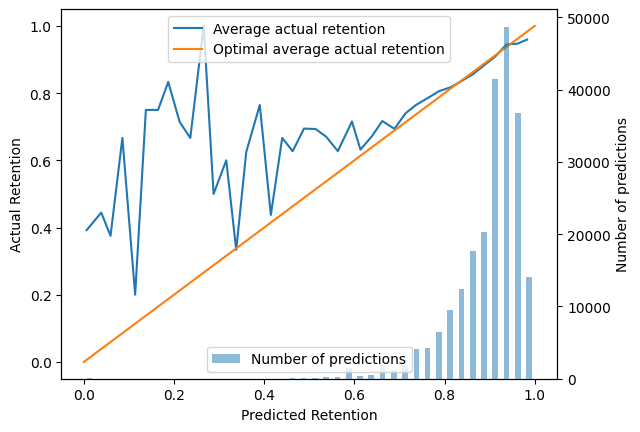

In [12]:
from sklearn.metrics import mean_squared_error, r2_score


# code from https://github.com/papousek/duolingo-halflife-regression/blob/master/evaluation.py
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    bin_prediction_means = brier['detail']['bin_prediction_means']
    bin_correct_means = brier['detail']['bin_correct_means']
    bin_counts = brier['detail']['bin_counts']
    r2 = r2_score(bin_correct_means, bin_prediction_means, sample_weight=bin_counts)
    rmse = np.sqrt(mean_squared_error(bin_correct_means, bin_prediction_means, sample_weight=bin_counts))
    print(f"R-squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    plt.figure()
    plt.plot(bin_prediction_means, bin_correct_means, label='Average actual retention')
    plt.plot((0, 1), (0, 1), label='Optimal average actual retention')
    bin_count = brier['detail']['bin_count']
    counts = np.array(bin_counts)
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Predicted Retention')
    plt.ylabel('Actual Retention')
    plt.twinx()
    plt.ylabel('Number of predictions')
    plt.bar(bins, counts, width=(0.5 / bin_count), alpha=0.5, label='Number of predictions')
    plt.legend(loc='lower center')


plot_brier(dataset['p'], dataset['y'], bins=40)
plt.show()